# Probabilistic polynomial linefitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy as sp
import time



In [2]:
def sample_proposal():
    # propose m1, m2, m3
    m1 = np.random.uniform(-30, 30)
    m2 = np.random.uniform(-10, 10)
    m3 = np.random.uniform(-0.1, 0.1)
    return np.array([m1,m2,m3])

def f1_sample():
    m1 = np.random.normal(0, 10)
    m2 = np.random.uniform(-10,10)
    m3 = np.random.uniform(-.1,.1)
    return np.array([m1,m2,m3])

def forward(m,x_obs):
    d = m[0] + m[1] * x_obs + m[2] * x_obs**2
    return d

def f2_pdf(d, d_obs, d_std):
    useLog = True
    f = -0.5 * np.sum((d_obs - d) ** 2 / (d_std ** 2))
    #f = exp(f)
    return f

def f1_pdf(m):
    fm1 = np.log(norm.pdf(m[0], 0, 10))

    if (m[1] > 10) or (m[1] < -10):
        fm2 = -np.inf
    else:
        fm2 = np.log(1 / 20)

    if (m[2] > 0.1) or (m[2] < -0.1):
        fm3 = -np.inf
    else:
        fm3 = np.log(1 / 0.2)

    f = fm1+fm2+fm3
    return f

def plot_sample_histogram(m_sample, nbins=100):
    plt.figure()

    plt.subplot(3, 1, 1)
    plt.hist(m_sample[:,0], bins=nbins, range=(-35, 35))
    plt.title('m1')

    plt.subplot(3, 1, 2)
    plt.hist(m_sample[:,1], bins=nbins, range=(-12, 12))
    plt.title('m2')

    plt.subplot(3, 1, 3)
    plt.hist(m_sample[:,2], bins=nbins, range=(-0.12, .12))
    plt.title('m3')

    plt.suptitle('1D marginal')

    

def plot_autocorrelation(m_post, maxlags=100, dlag=10):
    nm=m_post.shape[1]
    
    fig, ax = plt.subplots(nm, 1)
    for ix in range(nm):
        #plt.subplot(nm, 1, ix+1)
        ax[ix].acorr(m_post[::dlag, ix]-np.mean(m_post[:,ix]) , usevlines=False, maxlags=maxlags, normed=True, lw=2)
        ax[ix].set_title('m%d'%(ix+1))
        ax[ix].set_ylabel('Normalized \n Autocorrelation')
        ax[ix].grid()
        ax[ix].set_ylim([-.2, 1])
    plt.tight_layout()
    plt.xlabel('Lag (lag-distance=%d)' % dlag)

def plot_sample(m_sample, ax=None):

    nm=m_sample.shape[1]

    # construct ax and fig handle for three subplots
    # if ax is None do next line

    if ax is None:
        fig, ax = plt.subplots(nm, 1)

    for ix in range(nm):
        ax[ix].plot(m_sample[:,ix])
        ax[ix].grid()
        ax[ix].set_ylabel('m%d' % (ix+1) )
    ax[ix].set_xlabel('Iteration/realization number')
    plt.tight_layout()


    return ax

def plot_data(x_obs, d_obs, d_std):
    plt.errorbar(x_obs, d_obs, yerr=2*d_std, fmt='k.', linewidth=2,  label='Observations')
    plt.xlabel('x')
    plt.ylabel('d')
    plt.grid(True)
    plt.xlim([0, 50])



def plot_lines(m_sample, nshow=500):
    n = len(m_sample)
    nshow = min(n, nshow)

    for i in range(0, n, int(n / nshow)):
        d_test = forward(m_sample[i, :], x_test)
        plt.plot(x_test, d_test, 'r-', linewidth=.1)

## Load and plot the data

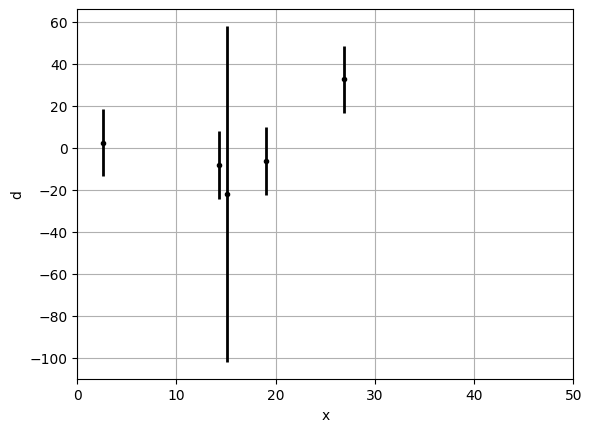

In [3]:
M=sp.io.loadmat('linefit_nd05.mat') # loads the data set with 5 observations
#M=sp.io.loadmat('linefit_nd35.mat') # loads the data set with 35 observations

d_obs = np.float32(M['d_obs'].flatten()) # Extract the 1D array from the loaded data
d_std = np.float32(M['d_std'].flatten())
x_obs = np.float32(M['x_obs'].flatten())
x_test = np.arange(0, 50, .1)
nx=len(x_test)
# show the data

plot_data(x_obs, d_obs, d_std)
plt.show()



In [4]:

# generate a sample from f1(m)
m = f1_sample()

# compupte f1(m)
f1 = f1_pdf(m)

# compupte f1(m)
d = forward(m, x_obs)
f2 = f2_pdf(d, d_obs, d_std)

# compute f12(m)
#f12 = f1 + f2 # all pdf valuess are in log space, so we can add them

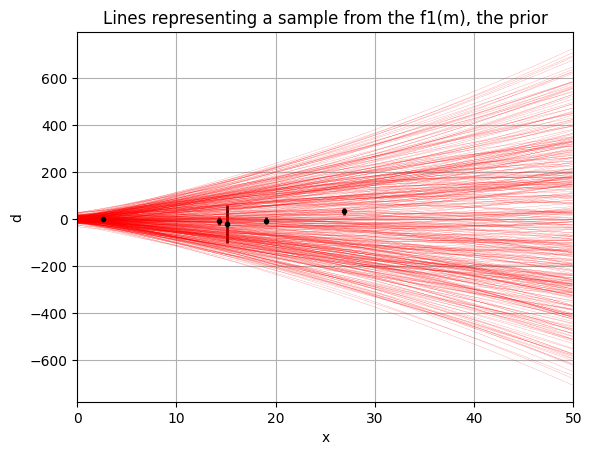

In [5]:

ns=400
m_prior = np.zeros((ns,3))
d_prior = np.zeros((ns,nx))

for i in range(ns):
    m = f1_sample()
    m_prior[i,:] = m
    d_test = forward(m, x_test)
    d_prior[i,:] = d_test
    d = forward(m, x_obs)



plt.figure(1)
plt.clf()
plot_data(x_obs, d_obs, d_std)
plot_lines(m_prior)
plt.title('Lines representing a sample from the f1(m), the prior')
plt.show()

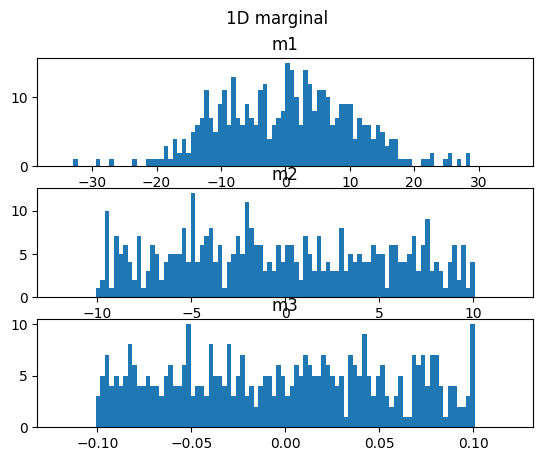

In [6]:
# make histograms of the sample from the proior
plot_sample_histogram(m_prior)

# The rejection sampler


In [7]:

if len(d_obs)==5:
    f_max = -6.2
else:   
    f_max = -26.24

T = 1 # 1 is no annealing

if len(d_obs)==5:
    N = 800000 # number of itearations
else:
    N = 4000000

# preallocate memory
m_post = np.zeros((N, 3))
f2_post = np.zeros(N)
f12_post = np.zeros(N)

iacc = -1
t0=time.time()
for i in range(N):
    
    # propose m1, m2, m3
    m_pro= sample_proposal()
    
    # compute f12 = f1*f2
    # f1 / direct
    f1 = f1_pdf(m_pro)
    # f2 / indirect
    d = forward(m_pro, x_obs)
    f2 = f2_pdf(d, d_obs, d_std)

    f12 = f1 + f2
    if f12 > f_max:
        f_max = f12+.01
        print(f'Updates f_max = {f_max} (!!!)')

    P_acc = np.exp(f12 - f_max) ** (1 / T)
    
    if np.random.rand() < P_acc:
        iacc += 1
        m_post[iacc,:] = m_pro
        f12_post[iacc] = f12

    if np.mod(i, 20000) == 0:
        print('i=%5d, Nacc = %4d, AcceptRatio = %f' %(i,iacc,iacc/(i+1)))


t=time.time()-t0
print('Time = %3.1fs.' % t)
print(f'Accepted %d of %d models, PacceptRatio = %5.4f' % (iacc,N,iacc/N))
print('%3.1f iterations per accepted model.' % (np.ceil(N/iacc)))

m_post=m_post[0:iacc,:]
f12_post=f12_post[0:iacc]

i=    0, Nacc =   -1, AcceptRatio = -1.000000
i=20000, Nacc =   26, AcceptRatio = 0.001300
i=40000, Nacc =   39, AcceptRatio = 0.000975
i=60000, Nacc =   62, AcceptRatio = 0.001033
i=80000, Nacc =   87, AcceptRatio = 0.001087
i=100000, Nacc =  107, AcceptRatio = 0.001070
i=120000, Nacc =  119, AcceptRatio = 0.000992
i=140000, Nacc =  130, AcceptRatio = 0.000929
i=160000, Nacc =  150, AcceptRatio = 0.000937
i=180000, Nacc =  169, AcceptRatio = 0.000939
i=200000, Nacc =  194, AcceptRatio = 0.000970
i=220000, Nacc =  210, AcceptRatio = 0.000955
i=240000, Nacc =  235, AcceptRatio = 0.000979
i=260000, Nacc =  256, AcceptRatio = 0.000985
i=280000, Nacc =  283, AcceptRatio = 0.001011
i=300000, Nacc =  308, AcceptRatio = 0.001027
i=320000, Nacc =  332, AcceptRatio = 0.001037
i=340000, Nacc =  354, AcceptRatio = 0.001041
i=360000, Nacc =  373, AcceptRatio = 0.001036
i=380000, Nacc =  392, AcceptRatio = 0.001032
i=400000, Nacc =  413, AcceptRatio = 0.001032
i=420000, Nacc =  433, AcceptRatio = 0

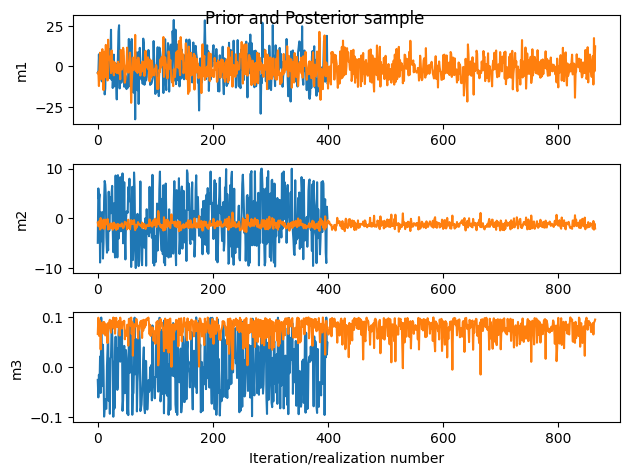

Text(0.5, 1.0, 'f12 values')

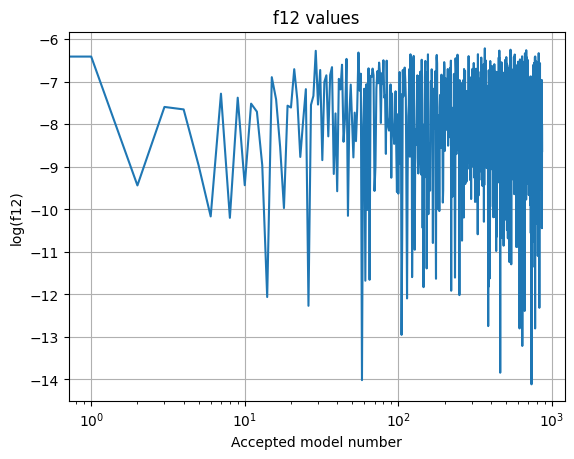

In [8]:

ax = plot_sample(m_prior)
plot_sample(m_post, ax)
plt.suptitle('Prior and Posterior sample')
plt.show()

plt.figure()
plt.semilogx(f12_post)
plt.ylabel('log(f12)')
plt.xlabel('Accepted model number')
plt.grid()
plt.title('f12 values')

## Estimate the number of independent realizations
N={{N}} realizations of the posterior distribution have been generated. The next step is to estimate the number of independent realizations. This can be done, for example, by computing the autocorrelation of the realizations of m1, m2, and m3.         

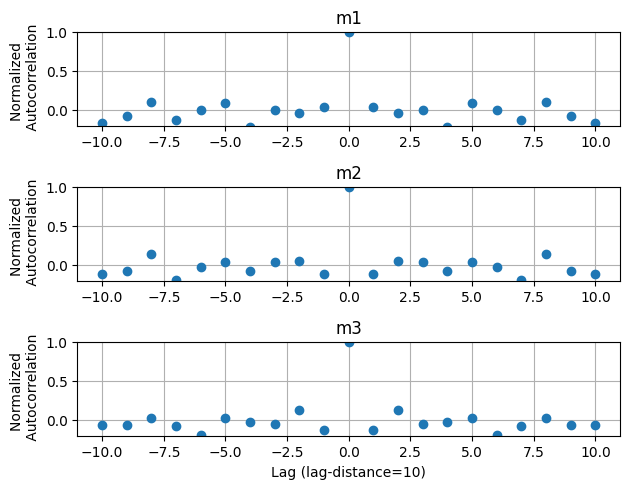

In [9]:
plot_autocorrelation(m_post, maxlags=10)

When the autocorrelation of the realizations of m1, m2, and m3 is close to zero, it suggest the number of iterations need to obtain an independent realization. 
The model parameter with thh longest autocorrelation is should be used for analysis.

If the number of iterations to reach an autocorrelation close to zero is $N_a=100$, then the number of independent realizations is approximately $N_{real}$=$N$/$N_a$.

The number of independent realizations needed depends on the what question is being asked. Here the goal is to approximate the 1D posterior distrution of the data at x=40, and around $N_{real}=1000$ should be sufficient to provide reproducible statistics with a resonable accuracy.

Text(0.5, 0.98, 'f12(m) - Posterior')

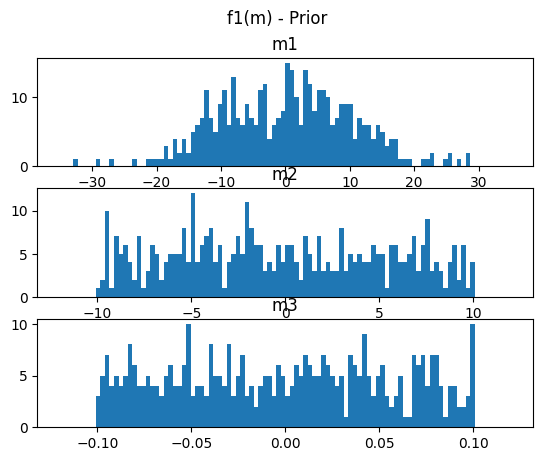

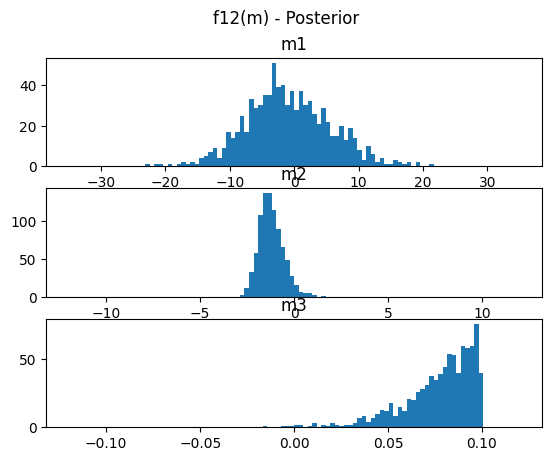

In [10]:
plot_sample_histogram(m_prior)
plt.suptitle('f1(m) - Prior')
plot_sample_histogram(m_post)
plt.suptitle('f12(m) - Posterior')

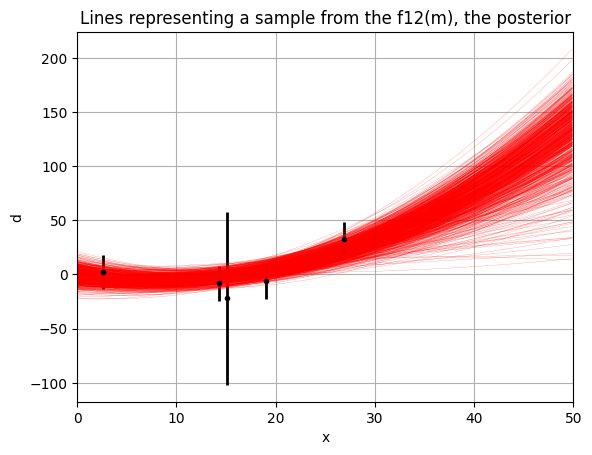

In [11]:

plt.figure(1)
plt.clf()
plot_data(x_obs, d_obs, d_std)
plot_lines(m_post)
plt.title('Lines representing a sample from the f12(m), the posterior')
plt.show()



## Compute the posterior distribution of the data at x=40
At this points a sample of the f12(m) has been generated. Rrealizations of the posterior pre-burnin has been removed, and we should have analyzed abobe that enough independent realizations have been generate to allow compuing the posterior statistics of interest.

Text(0.5, 0.98, 'P(d|x=40) - Prior and Posterior')

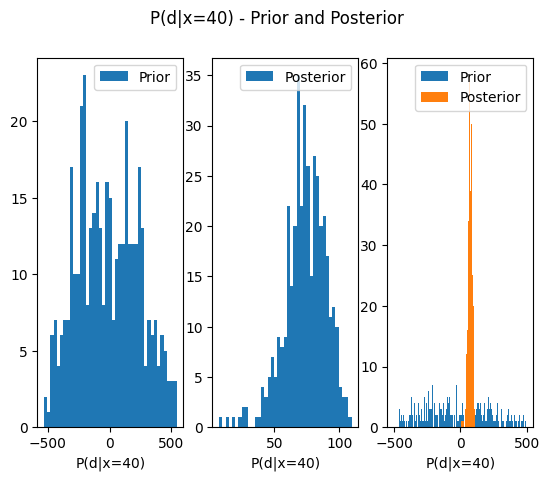

In [12]:
npr=m_prior.shape[0]
d40_prior=np.zeros(npr)
for i in range(npr):
    d40_prior[i]=forward(m_prior[i,:],40)

npo=m_post.shape[0]
d40_post=np.zeros(npr)
i_arr = np.ceil(np.arange(0,npo,npo/npr))
for i in range(npr):
    j=int(i_arr[i])
    d40_post[i]=forward(m_post[j,:],40)

plt.figure(4)
plt.subplot(1, 3, 1)
plt.hist(d40_prior, bins=41, label='Prior')
plt.xlabel('P(d|x=40)')
plt.legend()
plt.subplot(1, 3, 2)
plt.hist(d40_post, bins=41 , label='Posterior')
plt.xlabel('P(d|x=40)')
plt.legend()
plt.subplot(1, 3, 3)
plt.hist(d40_prior, bins=range(-500, 501, 5), label='Prior')
plt.hist(d40_post, bins=range(-500, 501, 5), label='Posterior')
plt.xlabel('P(d|x=40)')
plt.legend()
plt.suptitle('P(d|x=40) - Prior and Posterior')

95pp PRIOR conf interval [-447.1,462.1]
95pp POST conf interval [39.8,100.6]


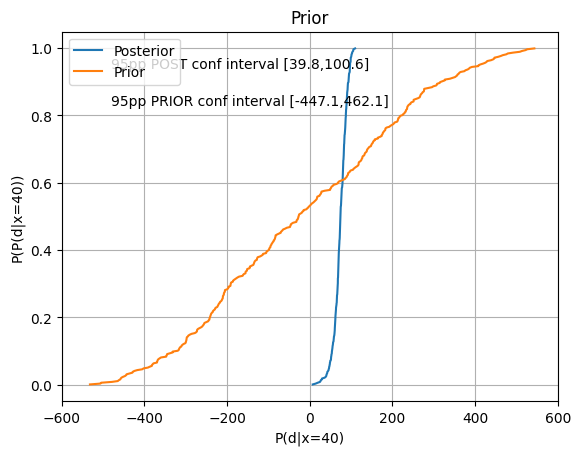

In [13]:

ns = len(d40_prior)
P = np.arange(1, ns + 1) / ns - (1 / (2 * ns))
sd40_prior = np.sort(d40_prior)
pr_p0025 = sd40_prior[int(np.ceil(ns * 0.025))]
pr_p0975 = sd40_prior[int(np.ceil(ns * 0.975))]
pr_txt = '95pp PRIOR conf interval [%3.1f,%3.1f]' % (pr_p0025, pr_p0975 )
print(pr_txt)

ns = len(d40_post)
P = np.arange(1, ns + 1) / ns - (1 / (2 * ns))
sd40 = np.sort(d40_post)
po_p0025 = sd40[int(np.ceil(ns * 0.025))]
po_p0975 = sd40[int(np.ceil(ns * 0.975))]
po_txt = '95pp POST conf interval [%3.1f,%3.1f]' % (po_p0025, po_p0975 )
print(po_txt)

plt.figure(5)
plt.plot(sd40, P, label='Posterior')
plt.xlabel('P(d|x=40)')
plt.ylabel('P(P(d|x=40))')
plt.legend()
plt.text(.1, .9, po_txt, transform=plt.gca().transAxes)
plt.title('Posterior')
plt.xlim([-600, 600])
plt.savefig(f'linefitA_N{len(d_obs)}_p40.png')

#plt.figure(6)
plt.plot(sd40_prior, P, label='Prior')
plt.xlabel('P(d|x=40)')
plt.ylabel('P(P(d|x=40))')
plt.text(.1, .8, pr_txt, transform=plt.gca().transAxes)
plt.title('Prior')
plt.xlim([-600, 600])
plt.grid()
plt.legend()
plt.savefig(f'linefitA_N{len(d_obs)}_p40_prior.png')



In [14]:
d_thres=77
P_prior = np.sum(d40_prior < d_thres) / len(d40_prior)
P_post = np.sum(d40_post < d_thres) / len(d40_post)
print('P(d<%3.1f | f1,prior) = %5.3f' % (d_thres, P_prior))
print('P(d<%3.1f | f12,post) = %5.3f' % (d_thres, P_post))



P(d<77.0 | f1,prior) = 0.608
P(d<77.0 | f12,post) = 0.575
